# Introduction
## The intuition is as follows:
## I wanted to use transformer-based models such as BERT as they have shown amazing results in various NLP tasks over the last few years. 
## Pre-trained models are especially helpful as they are supposed to contain more accurate representations of words and sentences.
## The idea is to use the most relevant tags in every movie to classify them (cluster)

In [ ]:
pip install -U sentence-transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/movielens/')
!ls

bert_clustering_tags.xlsx  link.csv	   rating.csv
genome_scores.csv	   movie.csv	   tag.csv
genome_tags.csv		   movie_tags.csv  tags_embeeding


# Setup
Let's get started by importing the required packages.

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [ ]:
pip install hdbscan

In [ ]:
pip install umap-learn

In [ ]:
import umap
import hdbscan

In [ ]:
#Ths is the fuction that will make the clustering
def clustering(embeddings, n_neighbors, n_components, d): #n_neighbors look at number of neighborhoods of each point when estimating the manifold structure of the data.
  umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, min_dist=d,
                            n_components=n_components, 
                            metric='cosine').fit_transform(embeddings)
  cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
  # Prepare data for visualization
  umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings) #metric='hellinger'
  result = pd.DataFrame(umap_data, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  return result
  

The very first step is converting the tags to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. I prefer to use the sentence-transformers package as the resulting embeddings have shown to be of high quality.

In [ ]:
from sentence_transformers import SentenceTransformer
#sentence_model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

We then download the genome_scores and tags

In [ ]:
def list_to_embed(a, b, relevance):
  genome_scores=pd.read_csv(a)
  genome_tags=pd.read_csv(b)
  #join both df
  genome=genome_scores.merge(genome_tags, on='tagId', how='inner')
  #sort_values by movie and relevance, in descending order
  genome=genome.sort_values(by=['movieId', 'relevance'],ascending=False)
  # only the tags that are relevant to each movie, I select the ones that have more that 80%
  #buscamos aquellos tag que tengan una relevancia mayor a 80%
  genome=genome.loc[genome.relevance>=relevance]
  # remove whitespaces 
  genome['tag']=genome.tag.str.replace(" ","")
  #join in one column
  genome_tag=genome.groupby(['movieId']).agg({'tag': ','.join}).reset_index()
  listados_list=genome_tag['tag'].to_list()
  return genome_tag, listados_list


In [ ]:
genome_tag, listados_list=list_to_embed('genome_scores.csv', 'genome_tags.csv', 0.80)

In [ ]:
genome_tag.head()

,movieId,tag
0,1,"toys,computeranimation,pixaranimation,kidsandf..."
1,2,"adventure,jungle,children,kids,specialeffects,..."
2,3,"goodsequel,sequel,sequels,comedy"
3,4,"women,chickflick,girliemovie"
4,5,"goodsequel,fatherdaughterrelationship,sequels,..."


In [ ]:
len(listados_list)

10160

In [ ]:
#process the embedding
embedding_bert = sentence_model.encode(listados_list, show_progress_bar=False)

In [ ]:
len(embedding_bert[0])

384

Try different numbers of components: and n_neighbors, the idea is to find a good fit that has the minimum number of outliers, points that the model can´t classify

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



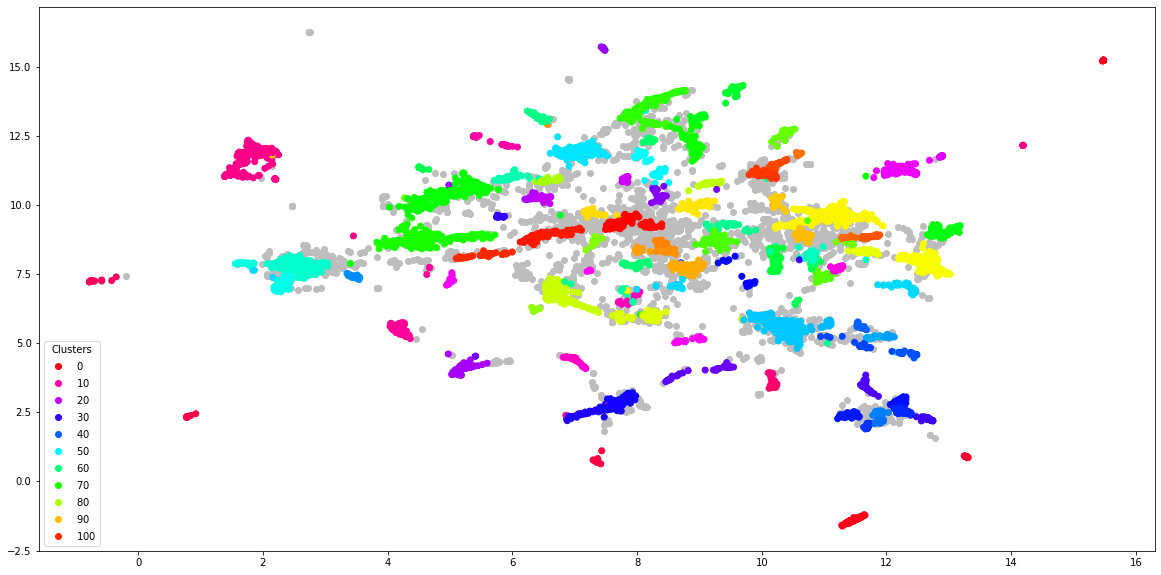

-1     2919
 68     364
 8      348
 47     299
 70     275
Name: labels, dtype: int64


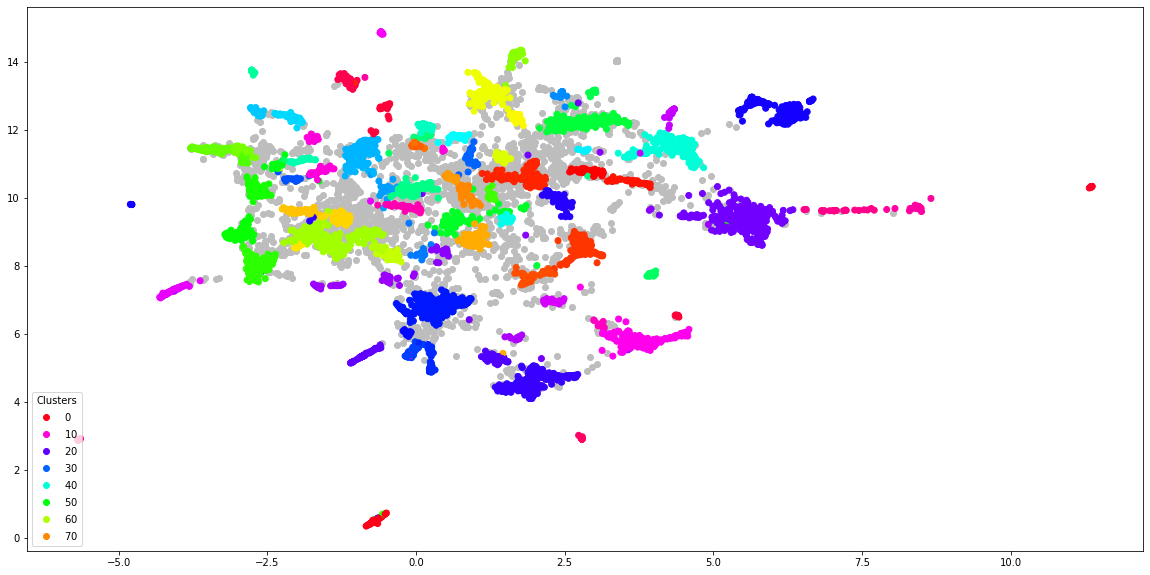

-1     2681
 19     578
 22     397
 26     386
 11     354
Name: labels, dtype: int64


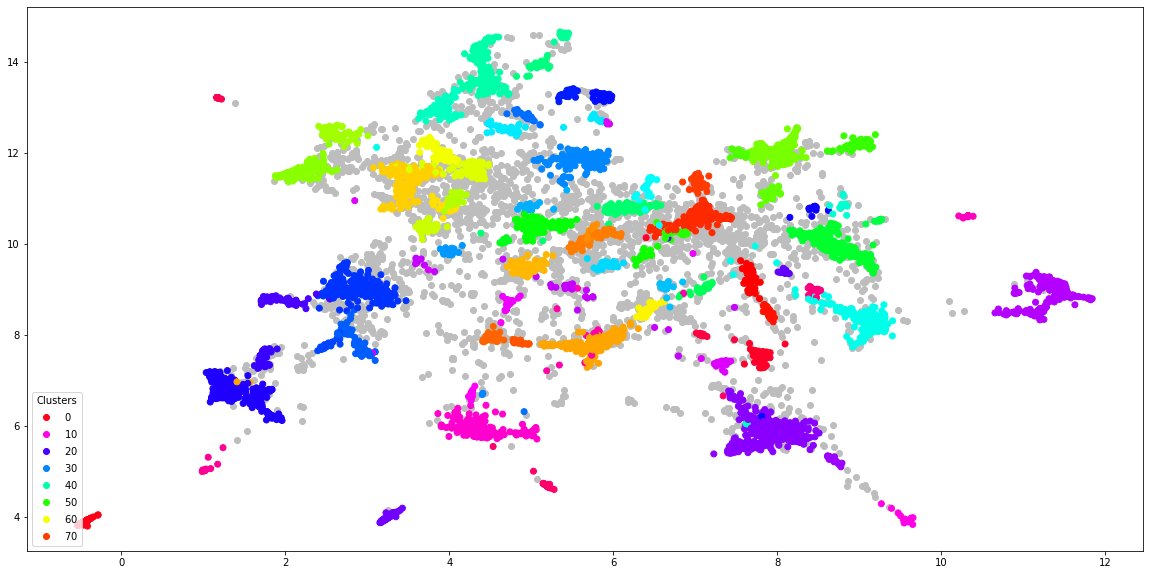

-1     3044
 17     490
 22     398
 26     352
 9      346
Name: labels, dtype: int64


In [ ]:
#number componentes
for n in ( 20, 50, 100):
    bert_clustering=clustering(embedding_bert, n, 10, 0.1)
    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = bert_clustering.loc[bert_clustering.labels == -1, :]
    clustered = bert_clustering.loc[bert_clustering.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
    scatter=plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
    legend1 = ax.legend(*scatter.legend_elements(),
                      loc="lower left", title="Clusters")
    #ax.add_artist(legend1)
    plt.show()
    print(bert_clustering['labels'].value_counts().head())

In [ ]:
#I ended up with this combination
bert_clustering=clustering(embedding_bert, 3, 10, 0.1)

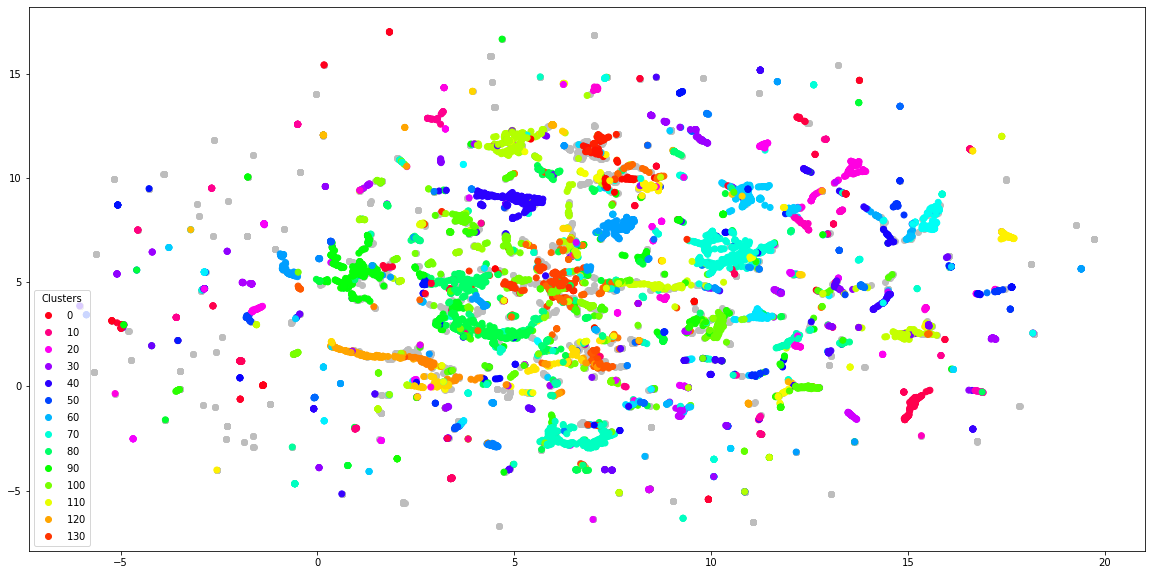

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = bert_clustering.loc[bert_clustering.labels == -1, :]
clustered = bert_clustering.loc[bert_clustering.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
scatter=plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r') #
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
#ax.add_artist(legend1)
plt.show()

In [ ]:

bert_clustering['labels'].value_counts().head()

-1     2074
 70     461
 89     373
 58     346
 40     308
Name: labels, dtype: int64

In [ ]:
# how many labels
bert_clustering['labels'].max()

135

In [ ]:
bert_clustering.shape

(10160, 3)

Merge with movies dataset for analysis

In [ ]:
movies=pd.read_csv('movie.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
bert_clustering["movieId"] = genome_tag["movieId"]
bert_clustering["tag"] = genome_tag["tag"]


In [ ]:
bert_clustering.head()

,x,y,labels,movieId,tag
0,5.558658,8.974567,40,1,"toys,computeranimation,pixaranimation,kidsandf..."
1,3.252170,9.400558,40,2,"adventure,jungle,children,kids,specialeffects,..."
2,-1.715821,3.162324,50,3,"goodsequel,sequel,sequels,comedy"
3,11.805183,3.366298,-1,4,"women,chickflick,girliemovie"
4,13.014766,7.359422,-1,5,"goodsequel,fatherdaughterrelationship,sequels,..."


In [ ]:
bert_clustering=bert_clustering.merge(movies, on='movieId', how='inner')

**Examples of movies**


In [ ]:
bert_clustering.loc[bert_clustering.movieId==2]

,x,y,labels,movieId,tag,title,genres
1,3.25217,9.400558,40,2,"adventure,jungle,children,kids,specialeffects,...",Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
bert_clustering.loc[bert_clustering.movieId==1]

,x,y,labels,movieId,tag,title,genres
0,5.558658,8.974567,40,1,"toys,computeranimation,pixaranimation,kidsandf...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
#movies with no cluster
bert_clustering.loc[bert_clustering.labels==-1]

,x,y,labels,movieId,tag,title,genres
3,11.805183,3.366298,-1,4,"women,chickflick,girliemovie",Waiting to Exhale (1995),Comedy|Drama|Romance
4,13.014766,7.359422,-1,5,"goodsequel,fatherdaughterrelationship,sequels,...",Father of the Bride Part II (1995),Comedy
5,6.778693,11.224786,-1,6,"crime,heist,gunfight,bankrobbery,greatacting,i...",Heat (1995),Action|Crime|Thriller
15,6.834200,11.236069,-1,16,"organizedcrime,mafia,mob,gangster,gangsters,ca...",Casino (1995),Crime|Drama
24,5.730867,10.302020,-1,25,"drinking,loneliness,melancholic,love,alcoholis...",Leaving Las Vegas (1995),Drama|Romance
...,...,...,...,...,...,...,...
10124,4.752386,4.905241,-1,127202,"terminalillness,comingofage,cancer,friendship,...",Me and Earl and the Dying Girl (2015),Drama
10125,1.465508,-0.372298,-1,127204,malenudity,The Overnight (2015),Comedy
10127,11.709372,-0.394168,-1,127212,"psychology,psychological,prison,worldpolitics,...",The Stanford Prison Experiment (2015),Drama|Thriller
10146,6.640062,5.609958,-1,129781,"suicide,writer'slife,friendship,grindhouse",About Alex (2014),Drama


# Topic Creation, for inspection
When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.
In here,the idea is treat all words in a single cluster as a single doc. and then apply TF-IDF-
The result would be a very long set of words per category and the resulting TF-IDF score would demonstrate the important words in a topic.

c-TF-IDF
To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [ ]:
bert_clustering.head()

,x,y,labels,movieId,tag,title,genres
0,5.558658,8.974567,40,1,"toys,computeranimation,pixaranimation,kidsandf...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3.252170,9.400558,40,2,"adventure,jungle,children,kids,specialeffects,...",Jumanji (1995),Adventure|Children|Fantasy
2,-1.715821,3.162324,50,3,"goodsequel,sequel,sequels,comedy",Grumpier Old Men (1995),Comedy|Romance
3,11.805183,3.366298,-1,4,"women,chickflick,girliemovie",Waiting to Exhale (1995),Comedy|Drama|Romance
4,13.014766,7.359422,-1,5,"goodsequel,fatherdaughterrelationship,sequels,...",Father of the Bride Part II (1995),Comedy


In [ ]:
words_per_topic=bert_clustering.groupby(['labels'], as_index = False).agg({'tag': ' '.join})


Then, we apply the class-based TF-IDF:


In [ ]:
words_per_topic.head()

,labels,tag
0,-1,"women,chickflick,girliemovie goodsequel,father..."
1,0,"spaceprogram,astronauts,nasa,space,spacetravel..."
2,1,comedy comedy comedy comedy comedy comedy come...
3,2,"stopmotion,stop-motion,weird,animation,origina..."
4,3,"camp,kids,funmovie comedy,teenmovie,roadtrip,g..."


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  


In [ ]:
tf_idf, count = c_tf_idf(words_per_topic.tag.values, m=len(bert_clustering))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.labels)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, words_per_topic, n=20)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
#Topic x
top_n_words[-1]

[('oscar', 0.04898895436807793),
 ('original', 0.031941606493525905),
 ('greatacting', 0.024642246495591564),
 ('drama', 0.02246693562860896),
 ('storytelling', 0.022459159350215925),
 ('imdbtop250', 0.022349360249517308),
 ('violence', 0.021922795346789186),
 ('bestdirecting', 0.02128551638244688),
 ('violent', 0.020234375093433468),
 ('mentor', 0.01997623796243457),
 ('comedy', 0.019823059921790773),
 ('dramatic', 0.018768422694819313),
 ('criterion', 0.018060993581079578),
 ('brutality', 0.017765605891128414),
 ('relationships', 0.01742266831078133),
 ('basedonabook', 0.01672597348955536),
 ('cinematography', 0.016574868683538677),
 ('bestactress', 0.016384756768807643),
 ('melancholic', 0.016296658787067604),
 ('tense', 0.016251635395979153)]

In [ ]:
#bert_clustering.to_excel('bert_clustering_tags_3_10_parap.xlsx')